In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional, Dropout, BatchNormalization
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2


In [ ]:

# Load the dataset
dataset_path = r"path_to_dataset"
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset to verify it's loaded correctly
print(df.head())


       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [3]:

# Perform sentiment analysis for each incoming call
sentiments = []
for text in df['text']:
    analysis = TextBlob(str(text))  # Convert to string to handle potential NaN values
    # Determine sentiment polarity (-1 for negative, 0 for neutral, 1 for positive)
    sentiment = 'Positive' if analysis.sentiment.polarity > 0 else 'Neutral' if analysis.sentiment.polarity == 0 else 'Negative'
    sentiments.append(sentiment)

# Add sentiment analysis results to the DataFrame
df['Sentiment'] = sentiments

# Display the DataFrame with sentiment analysis results
print(df.head())


       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Sentiment  
0  I`d have responded, if I were going   neutral   Neutral  
1                             Sooo SAD  negative  Negative  
2                          bullying me  negative   Neutral  
3                       leave me alone  negative   Neutral  
4                        Sons of ****,  negative   Neutral  


In [8]:
# Get the sentiment category counts from the 'Sentiment' column
sentiment_category_counts = df['Sentiment'].value_counts()

# Print the counts
print("Sentiment Analysis by Sentiment Category:\n", sentiment_category_counts)


Sentiment Analysis by Sentiment Category:
 Sentiment
Positive    12619
Neutral      9428
Negative     5434
Name: count, dtype: int64


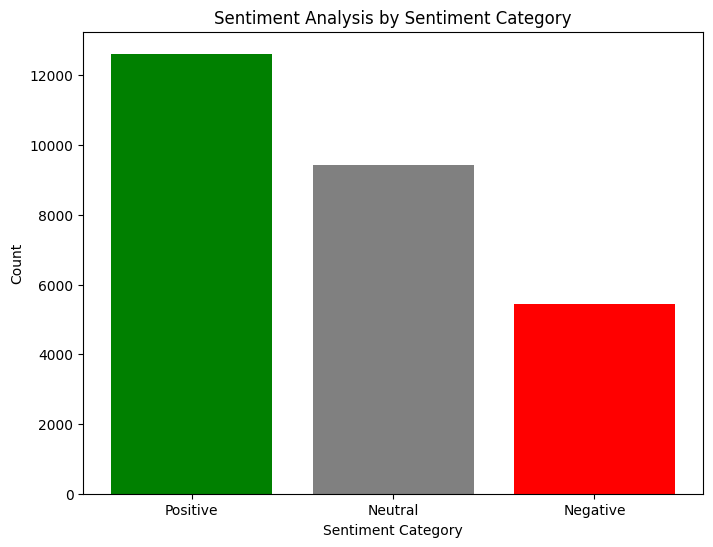

In [9]:
import matplotlib.pyplot as plt

# Data
sentiment_counts = {'Positive': 12619, 'Neutral': 9428, 'Negative': 5434}

# Plot
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'grey', 'red'])
plt.title('Sentiment Analysis by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()


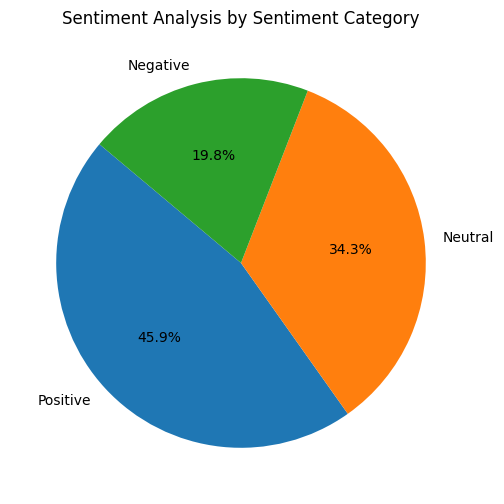

In [10]:
import matplotlib.pyplot as plt

# Define the sentiment counts
sentiment_counts = {
    'Positive': 12619,
    'Neutral': 9428,
    'Negative': 5434
}

# Plotting pie chart for sentiment analysis results
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Analysis by Sentiment Category')
plt.show()

In [4]:


# Split the dataset into training and testing sets
X = df['text'].astype(str).values  # Convert to string
y = pd.get_dummies(df['sentiment']).values  # Convert sentiment labels to one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len)

# Define number of epochs as an integer
epochs = 50

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint callback - CHANGED TO .keras FORMAT
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)  # Fixed format

# Build LSTM model with dropout and L2 regularization
embedding_dim = 128
lstm_out = 128

# Define the model - REMOVED input_length
model = Sequential()
model.add(Embedding(max_words, embedding_dim))  # Removed input_length
model.add(SpatialDropout1D(0.5))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping and model checkpoint
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=epochs,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
score = model.evaluate(X_test_pad, y_test, batch_size=32, verbose=1)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

# Print training and validation accuracy
print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])

# Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights - CHANGED TO CORRECT SUFFIX
model.save_weights("model_weights.weights.h5")  # Fixed suffix

# Specify the directory path where you want to save the tokenizer
save_dir = r"C:\Users\manil\Downloads\Call-sentiment-analysis-trial"
os.makedirs(save_dir, exist_ok=True)

# Save the tokenizer
tokenizer_path = os.path.join(save_dir, 'tokenizer.pickle')
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Tokenizer saved at: {tokenizer_path}")



Epoch 1/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 62s 85ms/step - accuracy: 0.4453 - loss: 1.3846 - val_accuracy: 0.6400 - val_loss: 0.8714
Epoch 2/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.6356 - loss: 0.8637 - val_accuracy: 0.6826 - val_loss: 0.7824
Epoch 3/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.7056 - loss: 0.7573 - val_accuracy: 0.7064 - val_loss: 0.7441
Epoch 4/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.7233 - loss: 0.7034 - val_accuracy: 0.7009 - val_loss: 0.7455
Epoch 5/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 88s 128ms/step - accuracy: 0.7344 - loss: 0.6790 - val_accuracy: 0.7151 - val_loss: 0.7258
Epoch 6/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - accuracy: 0.7556 - loss: 0.6472 - val_accuracy: 0.7013 - val_loss: 0.7640
Epoch 7/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - accuracy: 0.7615 - loss: 0.6314 - val_accuracy: 0.7137 - val_loss: 0.7211
Epoch 8/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - accuracy: 0.7713 - loss: 0.6099 -

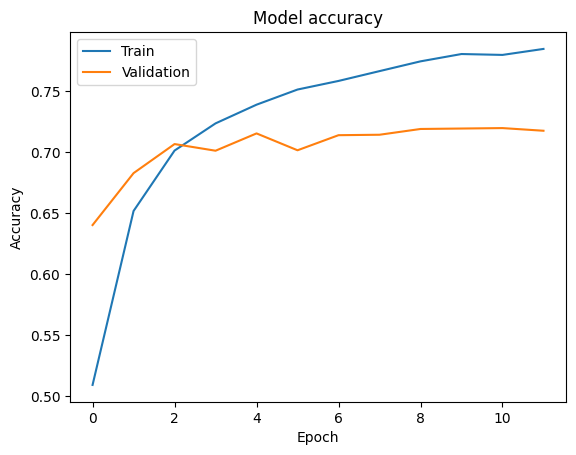

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




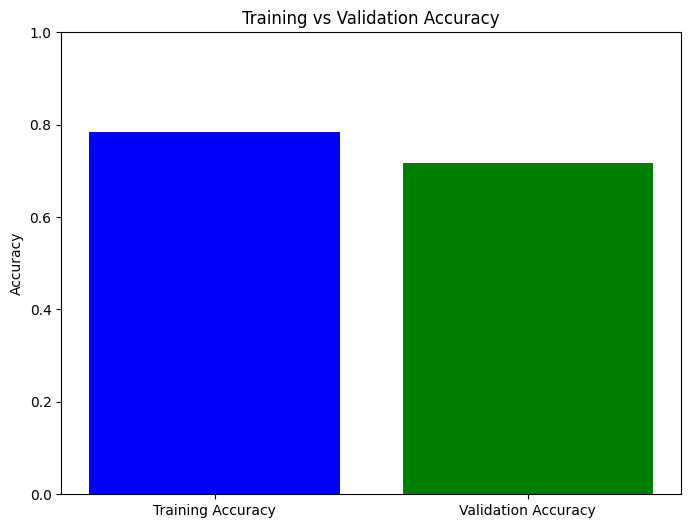

In [6]:
import matplotlib.pyplot as plt

# Get the final training and validation accuracy
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [training_accuracy, validation_accuracy], color=['blue', 'green'])
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()


In [ ]:


# Load the text data you want to predict sentiment for
text_data = ["This is a great movie!",
             "I'm not sure how I feel about this.",
             "I hated the ending of that book.",
             "Heyy it is very nice",
             "That is the worst score",
             "The Result of todays match is better but rcb lost it"]

# Tokenize the text
max_len = 100
X_sequences = tokenizer.texts_to_sequences(text_data)
X_pad = pad_sequences(X_sequences, maxlen=max_len)

# Load the saved model architecture
from tensorflow.keras.models import model_from_json  # Added missing import
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Load the model weights
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_weights.weights.h5")  # Corrected filename

# Predict sentiment
predictions = loaded_model.predict(X_pad)

# Decode predictions
sentiments = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
decoded_predictions = [sentiments[np.argmax(pred)] for pred in predictions]

# Print predictions
for text, pred in zip(text_data, decoded_predictions):
    print(f"Text: {text} \nPredicted Sentiment: {pred}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Text: This is a great movie! 
Predicted Sentiment: Positive

Text: I'm not sure how I feel about this. 
Predicted Sentiment: Negative

Text: I hated the ending of that book. 
Predicted Sentiment: Negative

Text: Heyy it is very nice 
Predicted Sentiment: Positive

Text: That is the worst score 
Predicted Sentiment: Negative

Text: The Result of todays match is better but rcb lost it 
Predicted Sentiment: Neutral



In [8]:
from keras.models import model_from_json

# Load the JSON model architecture
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Load the model architecture from JSON
loaded_model = model_from_json(loaded_model_json)

# Load the weights into the model
loaded_model.load_weights("model_weights.weights.h5")

# Print the summary of the loaded model
print(loaded_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 128)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (32, 100, 128)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (32, 128)              │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,315,915 (8.83 MB)

 Trainable params: 771,971 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,543,944 (5.89 MB)

None
